# Importing necessary libs and data

In [3]:
import json
api_token = {"username":"iobananaoi","key":"84cda1d87e243a61b9694f0ef68dc326"}


with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /root/.kaggle/kaggle.json

In [4]:
import gc
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchvision.transforms as T
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from kaggle.api.kaggle_api_extended import KaggleApi
from torchvision.datasets import ImageFolder
from zipfile import ZipFile
from PIL import Image
from tqdm import tqdm

In [5]:
api = KaggleApi()
api.authenticate()

In [6]:
!kaggle datasets download -d ikarus777/best-artworks-of-all-time

100% 2.28G/2.29G [00:12<00:00, 178MB/s]
100% 2.29G/2.29G [00:12<00:00, 197MB/s]


In [7]:
with ZipFile("/content/best-artworks-of-all-time.zip") as f:
    f.extractall()

# Important variables

In [8]:
# Folder with resized paintings
img_path = "/content/resized/"

# Batch size
batch_size = 32

# Mean of pictures
ds_mean = (5.1913e-05, 5.1913e-05, 5.1913e-05)

# Std of pictures
ds_std = (0.2115, 0.2115, 0.2115)

# Number of channels
nc = 3

# Size of feature map in generator
ngf = 32

# Image size (length and width)
ims = 400

# Size of latent vector for generator
nz = 100

# True_label
true_label = 1

# Fake_label 
fake_label = 0

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# DataLoader creation

In [9]:
transform = T.Compose([
    T.Resize((ims, ims)),
    T.ToTensor(),

])

paintings = ImageFolder(img_path, transform=transform)

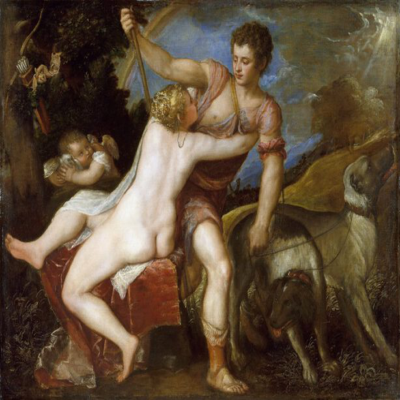

In [10]:
img = T.functional.to_pil_image(paintings[7500][0])
img

In [11]:
dataloader = DataLoader(paintings, batch_size, drop_last=True, shuffle=True)

# Model architecture

### Discriminator

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(nc, 32, kernel_size=(3, 3), padding=(1, 1), dilation=(1, 1)), 
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.MaxPool2d(2) # (batch_size, 32, 200, 200)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=(1, 1), dilation=(1, 1)), # (batch_size, 64, 200, 200)
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=(4, 4), stride=2, dilation=(2, 2)), # [batch_size, 64, 97, 97]
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=(5, 5)), # [batch_size, 128, 93, 93]
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(3) # (batch_size, 128, 31, 31)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=(6, 6), padding=(1, 1), dilation=(1, 1)),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=(5, 5), dilation=(2, 2)), 
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, stride=3, kernel_size=(4, 4)),
            nn.BatchNorm2d(256), # [batch_size, 256, 6, 6]
            nn.ReLU(True),

            nn.Conv2d(256, 1, kernel_size=1, stride=6),
            nn.Sigmoid() # [batch_size, 1, 1, 1]
        )


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(batch_size, -1) # [batch_size, 1]

        return x

### Generator

In [13]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, kernel_size=(7, 7)),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*8, ngf*4, kernel_size=(5, 5), stride=(1, 1)),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*4, ngf*4, kernel_size=(4, 4), stride=(2, 2)),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*4, ngf*2, kernel_size=(3, 3), stride=(2, 2)),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*2, ngf*2, kernel_size=(3, 3), stride=(2, 2)),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*2, ngf, kernel_size=(3, 3), stride=(2, 2)),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, kernel_size=(4, 4), stride=(2, 2)),

            nn.Tanh()
        )


    def forward(self, x):
        x = self.main(x) # [batch_size, 3, 400, 400]

        return x

# Model training

In [14]:
def discriminator_training_step(d, g, dopt, img_batch, criterion, batch_size):

    d.zero_grad()

    # Loss for true_imgs
    true_preds = d(img_batch).view(-1)
    label = torch.full((batch_size,), true_label, dtype=torch.float, device=device)

    errD_true = criterion(true_preds, label)
    errD_true.backward()

    noise = torch.randn(batch_size, nz, 1, 1, device=device)
    fake_imgs = g(noise) # Imgs generated by generator

    # Loss for fake_imgs
    fake_preds = d(fake_imgs).view(-1)
    label.fill_(fake_label)

    errD_fake = criterion(fake_preds, label)
    errD_fake.backward()

    errD = errD_true + errD_fake

    dopt.step()

    return fake_imgs, errD

In [15]:
def generator_training_step(d, g, gopt, fake_imgs, criterion, batch_size):
    g.zero_grad()

    fake_preds = d(fake_imgs).view(-1)
    label = torch.full((batch_size,), true_label, dtype=torch.float, device=device)

    errG = criterion(fake_preds, label)
    gopt.step()

    return errG

In [16]:
def train(d, g, dopt, gopt, dataloader, criterion, batch_size, epochs) -> tuple:
    fixed_noise = torch.randn(3, nz, 1, 1, device=device)
    img_list = []
    d_losses = []
    g_losses = []
    d_grads = []
    g_grads = []

    for epoch in range(1, epochs+1):
        print(f"======= Epoch {epoch} =======")

        for i, (img_batch, _) in tqdm(enumerate(dataloader)):
            img_batch = img_batch.to(device)

            # Discriminator training

            fake_imgs, errD = discriminator_training_step(d, g, dopt, img_batch, criterion, batch_size)
            d_losses.append(errD)

            # Generator training
            
            errG = generator_training_step(d, g, gopt, fake_imgs, criterion, batch_size)
            g_losses.append(errG)

            d_grads.append(torch.Tensor(list(d.parameters())[1]).sum().item())
            g_grads.append(torch.Tensor(list(g.parameters())[1]).sum().item())


            if i % 67 == 0:
                print(f"Batch {i}; LossD: {errD.item()}; LossG: {errG.item()}")


        with torch.no_grad():
            imgs = g(fixed_noise)
            img_list.append(imgs)     

    torch.save(g.state_dict(), "generator_l%.4f.pth" % g_losses[-1])
    torch.save(d.state_dict(), "discriminator_l%.4f.pth" % d_losses[-1])

    return img_list, d_losses, g_losses, d_grads, g_grads

In [17]:
g = Generator().to(device)
d = Discriminator().to(device)

dopt = optim.Adam(d.parameters())
gopt = optim.Adam(g.parameters())

criterion = nn.BCELoss()

In [ ]:
img_list, d_losses, g_losses, d_grads, g_grads = train(d, g, dopt, gopt, dataloader, criterion, batch_size, epochs=5)